In [40]:
import sys
print(sys.executable)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings
from autoviz.AutoViz_Class import AutoViz_Class
import sweetviz as sv
%matplotlib inline
warnings.filterwarnings("ignore")


c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Scripts\python.exe


# Functions:

In [3]:
def check_skewness(df, features, threshold=1):
    """
    Computes skewness for each feature in a list and flags if it's highly skewed.

    Parameters:
        df (pd.DataFrame): your dataset
        features (list): list of numeric feature names
        threshold (float): cutoff to label strong skew (default=1)

    Returns:
        pd.DataFrame with feature, skewness value, and skew type
    """
    results = []
    for col in features:
        skew = df[col].skew()
        if skew > threshold:
            skew_type = "Right-skewed"
        elif skew < -threshold:
            skew_type = "Left-skewed"
        else:
            skew_type = "Approximately normal"
        results.append({"Feature": col, "Skewness": round(skew, 3), "Type": skew_type})
    
    skew_df = pd.DataFrame(results).sort_values(by="Skewness", ascending=False)
    return skew_df


In [4]:
def plot_distributions_by_skewness(df, skew_table):
    """
    Plots each numeric feature based on its skewness result.
    Uses log scale for strongly skewed features.
    
    Parameters:
        df (pd.DataFrame): your dataset
        skew_table (pd.DataFrame): output from check_skewness()
    """
    
    for _, row in skew_table.iterrows():
        feature = row["Feature"]
        skew = row["Skewness"]
        skew_type = row["Type"]

        plt.figure(figsize=(7,4))
        if abs(skew) > 1:
            sns.histplot(np.log1p(df[feature]), bins=40, kde=True, color="orange", alpha=0.6)
            plt.title(f"{feature} (log-transformed for heavy skew, skew={skew:.2f})")
            plt.xlabel(f"log({feature} + 1)")
        else:
            sns.histplot(df[feature], bins=40, kde=True, color="skyblue", alpha=0.6)
            plt.title(f"{feature} Distribution (skew={skew:.2f}, {skew_type})")
            plt.xlabel(feature)
        
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


In [5]:
def detect_outliers_iqr(df, features):
    """
    Detect outliers for each numeric feature using the IQR method.
    Returns a summary DataFrame with counts and percentages.
    """
    results = []
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outlier_mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        outlier_count = outlier_mask.sum()
        outlier_percent = (outlier_count / len(df)) * 100
        
        results.append({
            "Feature": feature,
            "Q1": round(Q1, 2),
            "Q3": round(Q3, 2),
            "IQR": round(IQR, 2),
            "Lower Bound": round(lower_bound, 2),
            "Upper Bound": round(upper_bound, 2),
            "Outlier Count": outlier_count,
            "Outlier %": round(outlier_percent, 3)
        })
    
    return pd.DataFrame(results)


In [6]:
def add_remark(summary_table, col_name, remark):
    """
    Add a remark for a specific column in the summary_table.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
        col_name (str): Column name to mark.
        remark (str): Remark text to add.
    """
    summary_table.loc[summary_table['Feature'] == col_name, "remark"] = remark
    display(summary_table)


def status_check(summary_table):
    """
    Display all columns in summary_table that have no remark.
    Works for both empty strings and NaN values.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
    """
    unmarked = summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")]
    display(unmarked)


In [7]:
'load data'

df = pd.read_pickle("df_clean.pkl")

In [8]:
df.shape

(17292422, 26)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   cc_num            int64         
 1   gender            category      
 2   city              category      
 3   state             category      
 4   zip               int64         
 5   city_pop          int64         
 6   acct_num          int64         
 7   trans_date        datetime64[ns]
 8   trans_time        int32         
 9   unix_time         int64         
 10  category          category      
 11  amt               float64       
 12  is_fraud          int64         
 13  merchant          category      
 14  trans_month       category      
 15  trans_quarter     category      
 16  trans_day         int32         
 17  trans_dayofweek   category      
 18  trans_hour        category      
 19  age               int64         
 20  gender_encoded    int8          
 21  age_group  

In [10]:
df.drop(columns=['trans_date'], inplace=True)

In [11]:
df.shape

(17292422, 25)

<div style="background-color:#ddecfc; color:#100; padding:30px; border-radius:50px; max-width:1200px; margin:left;">
<font color='Navy'> <b><u><h2> Feature Summary (Categorized) </h2></b></u> </font>

| **Type** | **Columns** | **Description / Notes** |
|-----------|-------------|--------------------------|
| **Identifiers / Metadata** | `cc_num`, `acct_num` | Unique customer and account identifiers — not useful for modeling directly, but can help with grouping or traceability. |
| **Demographics** | `gender`, `age`, `age_group`, `job_category`, `location_profile` | Describe customer characteristics — useful for profiling and behavioral segmentation. |
| **Transaction Information** | `amt`, `category`, `merchant`, `trans_month`, `trans_day`, `trans_hour`, `trans_dayofweek`, `trans_quarter`, `trans_time_group` | Capture when, where, and how the transaction occurred — core predictors for fraud analysis. |
| **Geographic Information** | `city`, `state`, `zip`, `city_pop`, `distance_km` | Reflect location patterns and movement; large distances or unusual locations may indicate fraud. |
| **Encodings / Engineered Features** | `gender_encoded`, `unix_time`, `trans_time` | Derived or transformed variables that make the data machine-learning-ready. |
| **Target Variable** | `is_fraud` | Binary flag (0 = legitimate, 1 = fraud). The variable we aim to predict. |

---

### 🧩 Notes
- The dataset contains **25 columns** and **~518k transactions**.  
- Most categorical fields (e.g., `category`, `merchant`, `job_category`) are already clean and standardized.  
- There are **no missing values** after dropping the `region` column.  
- Numeric and categorical features are roughly balanced, allowing both statistical and visual exploration.

</font>


#### <font color='Navy'> 🔹Stratified random sample:
- since our data set is huge - i've decided to take a sample using strantified random sample.

In [12]:
# Stratified sampling to maintain fraud ratio
df_sample, _ = train_test_split(
    df, 
    test_size=0.97, 
    stratify=df['is_fraud'], 
    random_state=42
)
print(df_sample.shape)


(518772, 25)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17292422 entries, 0 to 34636366
Data columns (total 25 columns):
 #   Column            Dtype   
---  ------            -----   
 0   cc_num            int64   
 1   gender            category
 2   city              category
 3   state             category
 4   zip               int64   
 5   city_pop          int64   
 6   acct_num          int64   
 7   trans_time        int32   
 8   unix_time         int64   
 9   category          category
 10  amt               float64 
 11  is_fraud          int64   
 12  merchant          category
 13  trans_month       category
 14  trans_quarter     category
 15  trans_day         int32   
 16  trans_dayofweek   category
 17  trans_hour        category
 18  age               int64   
 19  gender_encoded    int8    
 20  age_group         category
 21  location_profile  category
 22  job_category      category
 23  trans_time_group  category
 24  distance_km       float64 
dtypes: category(13), floa

In [14]:
df_sample = df_sample.reset_index(drop=True)


In [15]:
df_sample.head(5)

,cc_num,gender,city,state,zip,city_pop,acct_num,trans_time,unix_time,category,amt,is_fraud,merchant,trans_month,trans_quarter,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,age_group,location_profile,job_category,trans_time_group,distance_km
0,4087053319705536,m,Milwaukee,WI,53206,817312,742734745331,16,1604488850,kids_pets,5.44,0,schimmelolson,11,4,4,2,16,44,1,adults_2550,urban,other,Afternoon,71.77
1,6552516675384246,m,Hammond,LA,70403,47940,646542117633,13,1601368114,kids_pets,7.30,0,beerjast,9,3,29,1,13,19,1,young_adults,urban,arts/media,Afternoon,104.27
2,4973157083855870466,m,Jackson,MO,63755,24006,938655990723,19,1595425347,home,27.57,0,witting beer and ernser,7,3,22,2,19,38,1,adults_2550,urban,technology,Evening,92.24
3,4033788237533792,m,Garden Grove,CA,92840,172782,863926196885,14,1592558509,health_fitness,6.31,0,friesen ltd,6,2,19,4,14,17,1,young_adults,urban,science/engineering,Afternoon,107.45
4,2579241170384868,m,Tampa,FL,33615,717255,746694632049,16,1609238799,travel,43.27,0,schroeder wolff and hermiston,12,4,29,1,16,72,1,adults_50up,urban,education,Afternoon,65.80


In [16]:
#sample into pickel:
df_sample.to_pickle("df_sample.pkl")

In [17]:
df = pd.read_pickle("df_sample.pkl")

In [18]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
cc_num,518772.0,3.722211e+17,1.238010e+18,6.040003e+10,3.850127e+13,3.505846e+15,4.589016e+15,4.999689e+18
zip,518772.0,5.108589e+04,2.965204e+04,1.002000e+03,2.760300e+04,4.810500e+04,7.824000e+04,9.992900e+04
city_pop,518772.0,2.954341e+05,5.679304e+05,4.400000e+01,1.778400e+04,6.089200e+04,2.366600e+05,2.906700e+06
acct_num,518772.0,4.978119e+11,2.891062e+11,1.837412e+07,2.465984e+11,4.972499e+11,7.505190e+11,9.999583e+11
trans_time,518772.0,1.676130e+01,4.532307e+00,0.000000e+00,1.400000e+01,1.700000e+01,2.000000e+01,2.300000e+01
unix_time,518772.0,1.595246e+09,9.062085e+06,1.577818e+09,1.587835e+09,1.595409e+09,1.603292e+09,1.609439e+09
amt,518772.0,6.595539e+01,1.987641e+02,1.000000e+00,8.230000e+00,3.329000e+01,7.661000e+01,3.181458e+04
is_fraud,518772.0,5.420493e-03,7.342426e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trans_day,518772.0,1.585100e+01,8.842200e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.400000e+01,3.100000e+01
age,518772.0,4.127197e+01,1.788398e+01,1.100000e+01,2.700000e+01,3.900000e+01,5.300000e+01,9.300000e+01


<font color='Navy'> <b><u><h4> Describe Summary (Categorized) </h4></b></u> 

- `cc_num`  & `acct_num` - very large numbers, identifier numbers - not really intresting.
- `zip` - 
- `city pop` - hits about being skewed towards the larger city populations (median < mean>) range is huge 44K to about 29 M.
- `trans time` - 0-23 hrs, mean is close to medain arount the afternoon 4PMs to 5PMs time.\
- `amt` - wide range, and abnormal Max value indicating outlier, very far from mean and median. STD - also high, indicating large range of transaction values. 
- `is_fraud` - 0.0054,, indicating and imbalanced class (outcome) set.
- `age` - range 11 to 93, mean 41 median 39 (pretty close) +-17 stdev
</font>

<div style="background-color:#f4f9fe ; color:#200; padding:30px; border-radius:50px;max-width:1200px; margin:left;">
<font color='Navy'> <b><u><h2> Traget Value: </h2></b></u> </font>

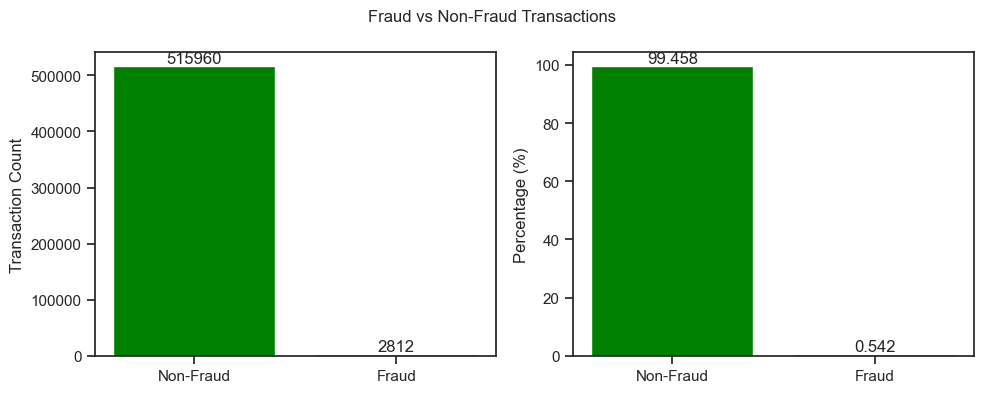

,Transaction Count,Percentage (%)
is_fraud,,
Non-Fraud,515960,99.458
Fraud,2812,0.542


In [43]:
fraud_counts = df["is_fraud"].value_counts().rename({0: "Non-Fraud", 1: "Fraud"})
fraud_percentage = (fraud_counts / len(df) * 100).round(3)

fraud_summary = pd.DataFrame({
    "Transaction Count": fraud_counts,
    "Percentage (%)": fraud_percentage
})

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Fraud vs Non-Fraud Transactions", fontsize=12)
axes[0].bar(fraud_summary.index, fraud_summary["Transaction Count"], color=['green', 'red'])
axes[0].set_ylabel("Transaction Count")
axes[0].bar_label(axes[0].containers[0])

axes[1].bar(fraud_summary.index, fraud_summary["Percentage (%)"], color=['green', 'red'])
axes[1].set_ylabel("Percentage (%)")
axes[1].bar_label(axes[1].containers[0])


plt.tight_layout()
plt.show()

fraud_summary

<font color='Navy'> <b><u><h4> findings: </h4></b></u>
- It appears that fraud cases are rare. only 0.54% are fraud cases.
- we can conclude that our data set is <b> imbalanced</b>.
- for imbalanced datasets, we must:
    - Use better metrics (like Precision, Recall, F1, ROC-AUC — not accuracy).
    - Use balanced sampling or class weighting when training models.
    - During EDA, analyze each class separately (fraud vs non-fraud distributions).
</font>

| Step   | What It Answers                           | Tools / Outputs                            |
| ------ | ----------------------------------------- | ------------------------------------------ |
| **2A** | “What’s the overall class balance?”       | Target distribution summary & plot         |
| **2B** | “How do key numeric features behave?”     | Histograms, boxplots, correlation heatmap  |
| **2C** | “How do categorical features behave?”     | Bar charts, fraud-rate comparisons         |
| **2D** | “How are features related to each other?” | Correlation matrix & scatter relationships |


<div style="background-color:#f4f9fe ; color:#200; padding:30px; border-radius:50px;max-width:1200px; margin:left;">
<font color='Navy'>
<u>

# Class Specific View - Continues
</u>
- How do these distributions differ between fraud and non-fraud

- Let's look at the same metrics (mean, median, std, min, max) but broken down by is_fraud
    - which shows you directional patterns that describe fraud behavior ?

This step helps us:
- understand which features might be predictive,
- spot extreme outliers or data issues,
- and see whether we need transformations or scaling later.

</font></div>

In [29]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
print(f"Numeric features : {numeric_features}")
# simpler removal — drop unwanted columns directly like IDs and target
numeric_features = numeric_features.drop(['cc_num', 'acct_num','is_fraud', 'zip', 'unix_time'], errors='ignore').tolist()

print(f"Numeric continues features {numeric_features}")


Numeric features : Index(['cc_num', 'zip', 'city_pop', 'acct_num', 'unix_time', 'amt', 'is_fraud',
       'age', 'distance_km'],
      dtype='object')
Numeric continues features ['city_pop', 'amt', 'age', 'distance_km']


In [30]:
# Check skewness of numeric features:
skewness_df = check_skewness(df, numeric_features)
skewness_df

,Feature,Skewness,Type
1,amt,47.613,Right-skewed
0,city_pop,2.915,Right-skewed
2,age,0.691,Approximately normal
3,distance_km,-0.239,Approximately normal


In [ ]:
def plot_feature_distribution(df, feature, target="is_fraud"):
    plt.figure(figsize=(7, 4))
    sns.kdeplot(
        data=df,
        x=feature,
        hue=target,
        fill=True,
        common_norm=False,
        alpha=0.5,
        palette={0: "skyblue", 1: "salmon"}
    )
    plt.xlim(left=0)  # removes the misleading negative tail
    plt.title(f"{feature} Distribution by Fraud Status", fontsize=12, fontweight="bold")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


#### <font color='Navy'> 🔹Continues Feautre = 'amt' Evaluation :

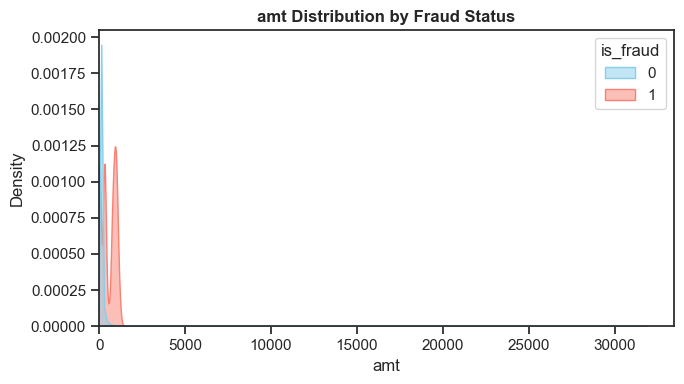

In [46]:
feature = "amt"
plot_feature_distribution(df, feature)


#### <font color='Navy'> 🔹Initial Observation:
- Strong right skew + very few extreme values (density closer to 0):
    - Possible outliers
    - Higher amounts of transactions are rare.
- No Fraud Cases Tend to be for smaller amounts of transactions (high narrow line at lower values)
- Fraud cases : flatter and shifted to the right (2 peaks) - tend to be for larger amounts of transactions
- *** Distictive Pattern *** :
    - while both pattern overlap at lower amounts, there is a distiction in higher amounts.

#### <font color='Navy'> 🔹Conclusion:
1. Predictive: Strong fraud indicator — higher amounts linked to fraud.
2. Skewness: Heavily right-skewed → apply log/robust scaling.
3. Outliers: Likely Present — review in data-cleaning phase.
4. Distribution: Non-fraud = low amounts; fraud = higher, spread out.
5. Action: Keep feature, scale down, and monitor outliers.

In [47]:
df_continues_summary = skewness_df.copy()
df_continues_summary.remove_columns = ['index']


In [53]:
add_remark(df_continues_summary, "amt", "Predictive | Scale Required | Check Outliers")


,Feature,Skewness,Type,remark
1,amt,47.613,Right-skewed,Predictive | Scale Required | Check Outliers
0,city_pop,2.915,Right-skewed,NaN
2,age,0.691,Approximately normal,NaN
3,distance_km,-0.239,Approximately normal,NaN


#### <font color='Navy'> 🔹Continues Feautre = 'city pop' Evaluation :

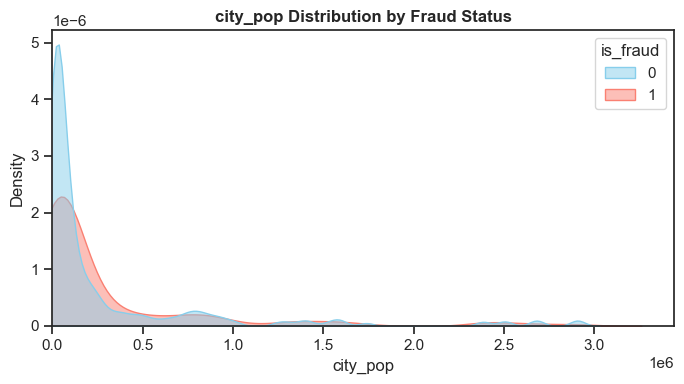

In [50]:
plot_feature_distribution(df, "city_pop")

#### <font color='Navy'> 🔹Initial Observation:
- Both `fraud` and ` no_frad` cases are strongly skeweed to the right
    - Most Transactions are from smaller populations.
    - Possible outliers case, need to check in data clean.
    
- *** Distictive Pattern *** :
    - Both curves seem to mostly overlap in pattern (higher density in lower population) with no clear sperator at first glance.

#### <font color='Navy'> 🔹Conclusion:
1. Predictivity: Possible Limited standalone predictive power.
2. Skewness: Right-skewed → apply log/robust scaling.
3. Outliers: Possibly Present — review in data-cleaning phase.
4. Distribution: Non-fraud = low amounts; fraud = higher, spread out.
5. Action: Keep feature, scale down, and monitor outliers.

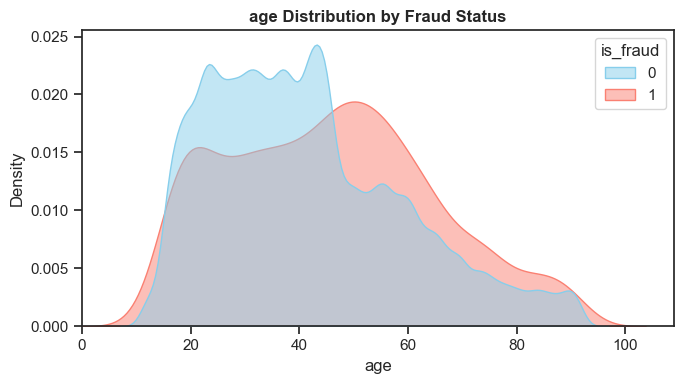

In [54]:
plot_feature_distribution(df, "age")

📊 Feature: amt
------------------------------------------------------------
Skewness: 47.613


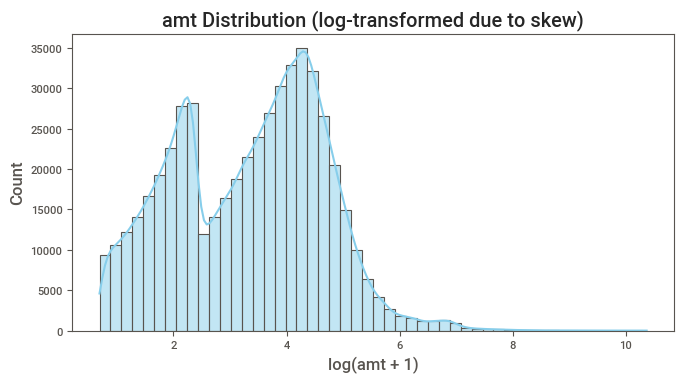

Outliers: 29308 (5.65% of data)


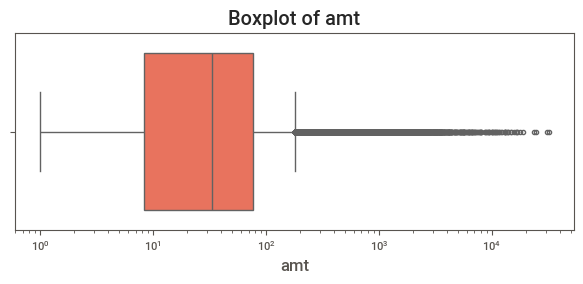

------------------------------------------------------------


In [144]:
def analyze_feature(df, feature):
    print(f"📊 Feature: {feature}")
    print("-" * 60)
    
    # 1️⃣ Skewness
    skew_val = df[feature].skew()
    print(f"Skewness: {skew_val:.3f}")
    
    # 2️⃣ Distribution plot
    plt.figure(figsize=(7,4))
    
    if abs(skew_val) > 1:
        sns.histplot(np.log1p(df[feature]), bins=50, kde=True, color="skyblue")
        plt.title(f"{feature} Distribution (log-transformed due to skew)")
        plt.xlabel(f"log({feature} + 1)")
    else:
        sns.histplot(df[feature], bins=50, kde=True, color="skyblue")
        plt.title(f"{feature} Distribution")
        plt.xlabel(feature)
        
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # 3️⃣ Outlier detection using IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outlier_count = ((df[feature] < lower) | (df[feature] > upper)).sum()
    outlier_pct = outlier_count / len(df) * 100
    
    print(f"Outliers: {outlier_count} ({outlier_pct:.2f}% of data)")
    
    # 4️⃣ Boxplot
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[feature], color='tomato')
    plt.title(f"Boxplot of {feature}")
    plt.xscale('log' if abs(skew_val) > 1 else 'linear')
    plt.tight_layout()
    plt.show()
    
    print("-" * 60)

# Example usage:
analyze_feature(df, "amt")


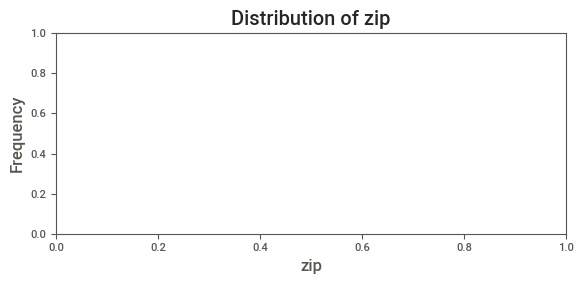

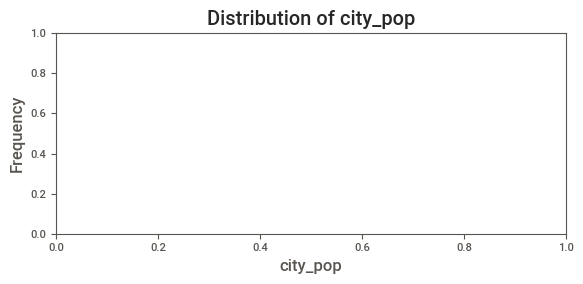

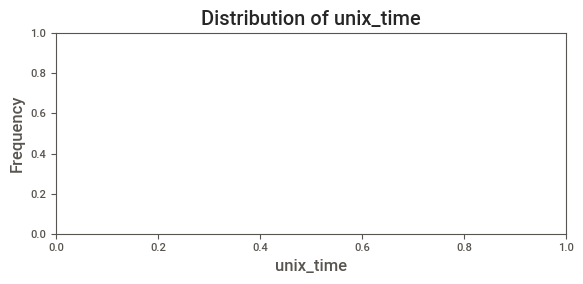

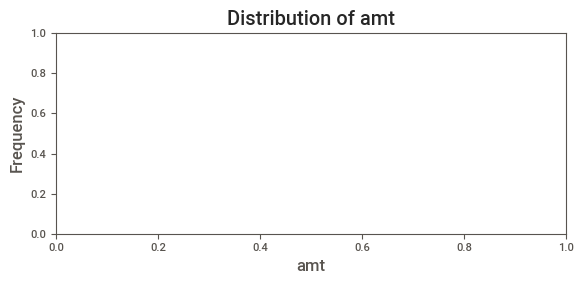

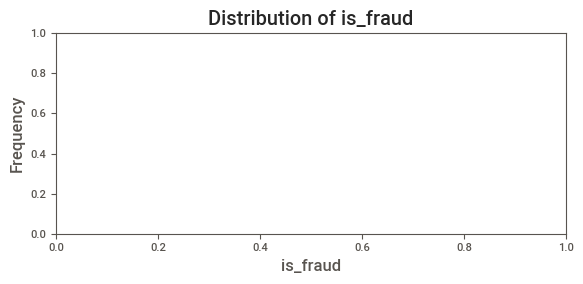

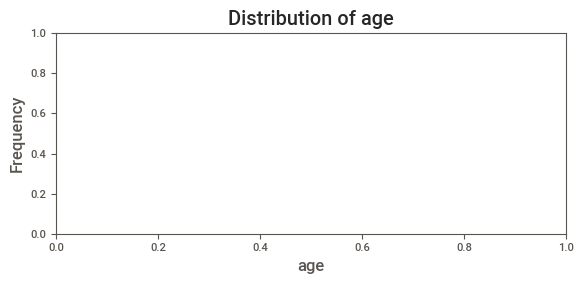

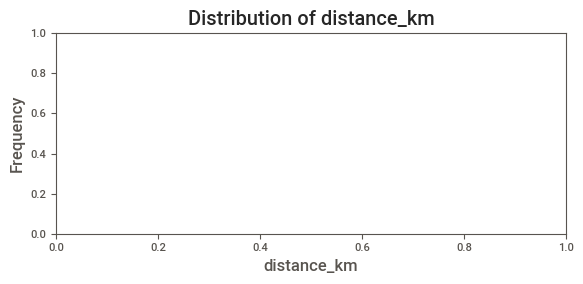

In [134]:
for col in numeric_features:
    plt.figure(figsize=(6,3))
    df[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [ ]:
# --------------------------------------------------
# Step 2A — Fixed Version (Class-Conditional Numeric Summary)
# --------------------------------------------------

numeric_focus = ["amt", "distance_km", "age", "city_pop"]

def summary_by_class(df, cols, target="is_fraud"):
    out_frames = []
    for c in cols:
        g = df.groupby(target)[c].agg(["count", "mean", "median", "std", "min", "max"]).reset_index()
        g.insert(1, "feature", c)
        out_frames.append(g)
    res = pd.concat(out_frames, ignore_index=True)
    res[target] = res[target].map({0: "Non-Fraud", 1: "Fraud"})
    res = res.round(3)
    return res

summary_table = summary_by_class(df, numeric_focus, target="is_fraud")
summary_table


,is_fraud,feature,count,mean,median,std,min,max
0,Non-Fraud,amt,515960,63.335,33.080,193.924,1.00,31814.58
1,Fraud,amt,2812,546.790,614.080,394.775,2.16,1269.08
2,Non-Fraud,distance_km,515960,76.495,78.710,29.195,0.06,150.86
3,Fraud,distance_km,2812,77.883,79.765,28.599,0.84,145.59
4,Non-Fraud,age,515960,41.247,39.000,17.873,11.00,93.00
5,Fraud,age,2812,45.871,46.000,19.181,11.00,92.00
6,Non-Fraud,city_pop,515960,295351.024,60892.000,567883.336,44.00,2906700.00
7,Fraud,city_pop,2812,310683.892,68896.000,576408.683,120.00,2906700.00


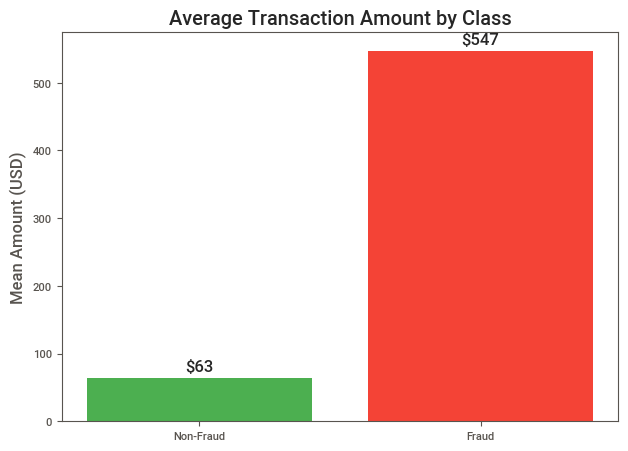

In [116]:
import matplotlib.pyplot as plt

avg_amt = df.groupby("is_fraud")["amt"].mean()

plt.bar(["Non-Fraud", "Fraud"], avg_amt, color=["#4CAF50", "#F44336"])
plt.title("Average Transaction Amount by Class")
plt.ylabel("Mean Amount (USD)")
for i, v in enumerate(avg_amt):
    plt.text(i, v + 10, f"${v:,.0f}", ha="center", fontweight="bold")
plt.show()


    Since nrows is smaller than dataset, loading random sample of 300000 rows into pandas...
Shape of your Data Set loaded: (300000, 26)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  12
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  10
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    25 Predictors classified...
        No variables removed since no ID or low-information variables found in data 

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
cc_num,int64,0.000000,5,60400026104.000000,4999688876050253824.000000,Column has 24667 outliers greater than upper bound (11416735129338324.00) or lower than lower bound(-6788421244037941.00). Cap them or remove them.
gender,category,0.000000,0,,,No issue
city,category,0.000000,1,,,5034 rare categories: Too many to list. Group them into a single category or drop the categories.
state,category,0.000000,0,,,22 rare categories: Too many to list. Group them into a single category or drop the categories.
zip,int64,0.000000,3,1002.000000,99929.000000,No issue
city_pop,int64,0.000000,1,44.000000,2906700.000000,Column has 49067 outliers greater than upper bound (557693.00) or lower than lower bound(-306243.00). Cap them or remove them.
acct_num,int64,0.000000,5,18374117.000000,999958349264.000000,No issue
trans_time,int32,0.000000,0,0.000000,23.000000,Column has 7981 outliers greater than upper bound (29.00) or lower than lower bound(5.00). Cap them or remove them.
unix_time,int64,0.000000,98,1577817711.000000,1609439341.000000,No issue
category,category,0.000000,0,,,"6 rare categories: ['shopping_net', 'grocery_pos', 'misc_net', 'gas_transport', 'misc_pos', 'grocery_net']. Group them into a single category or drop the categories."


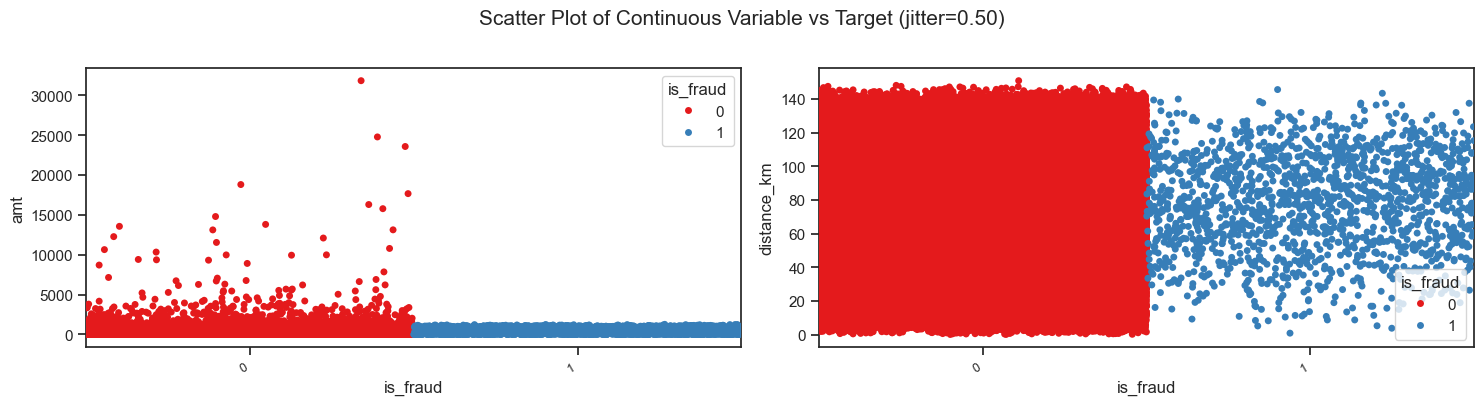

Total Number of Scatter Plots = 3


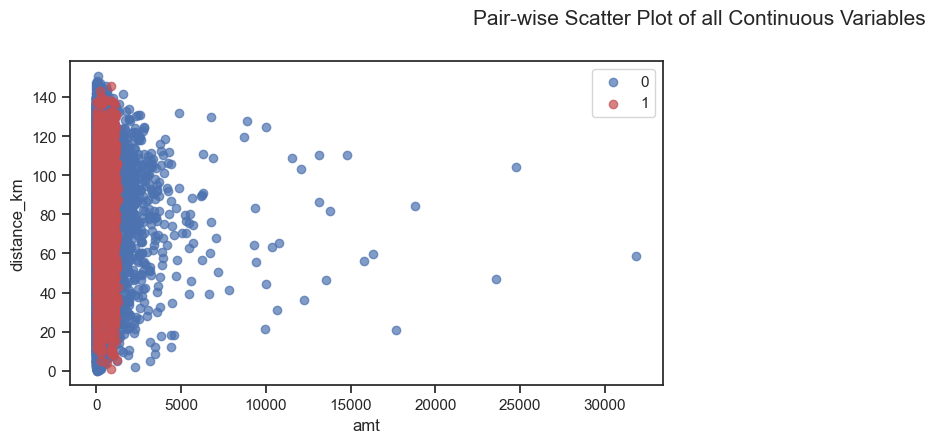

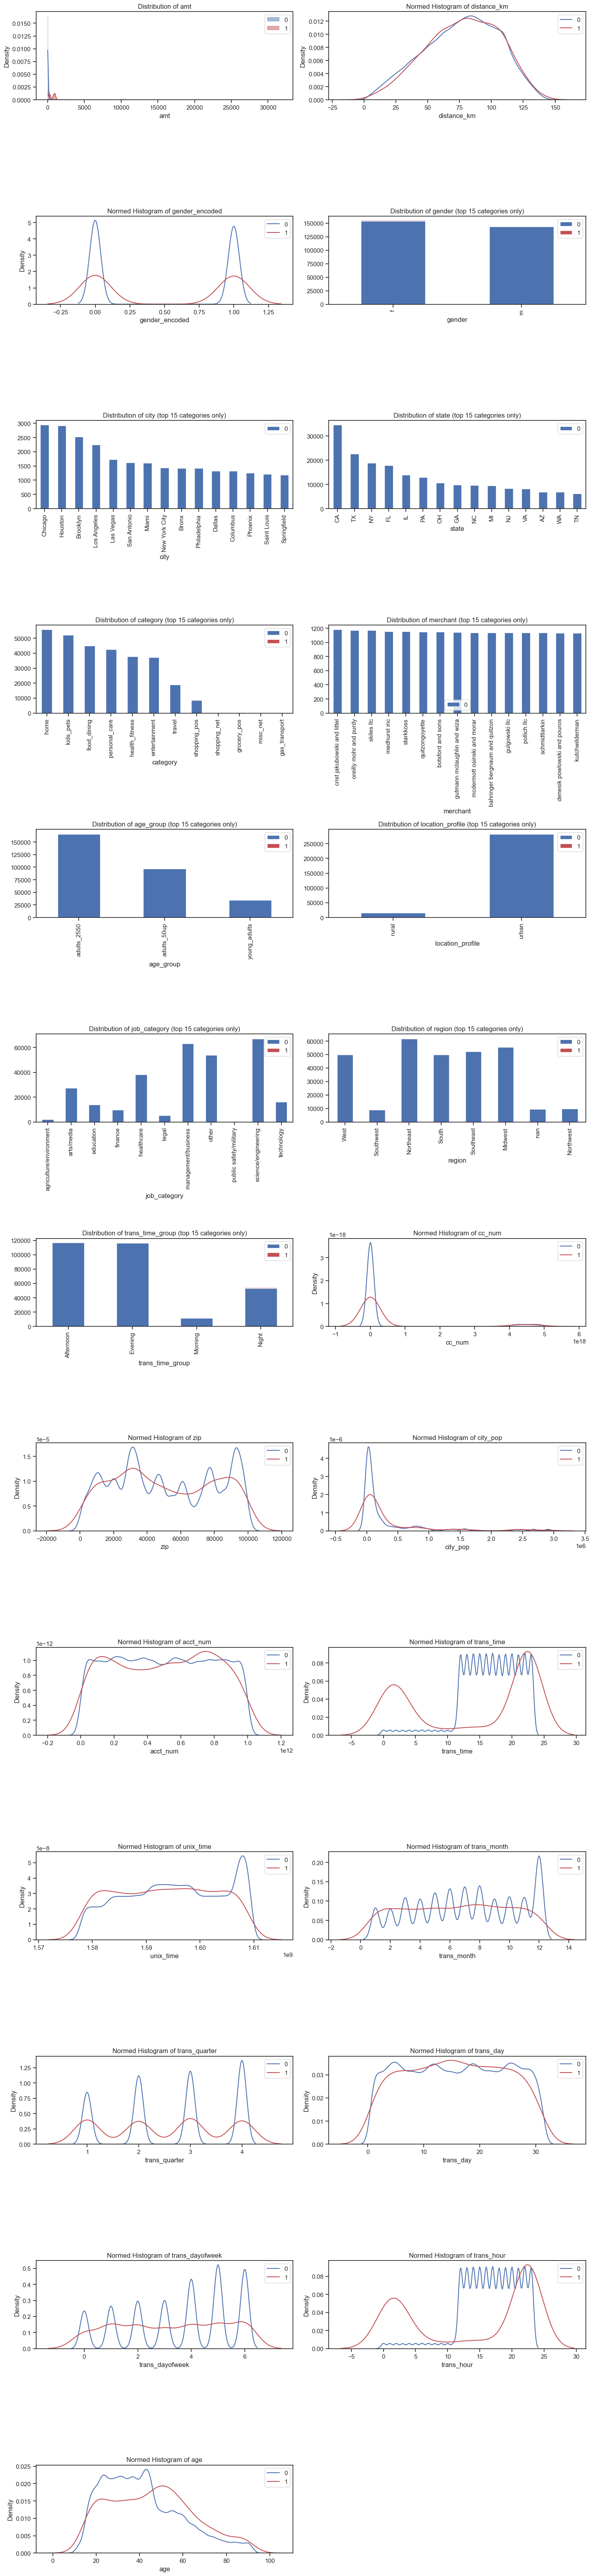

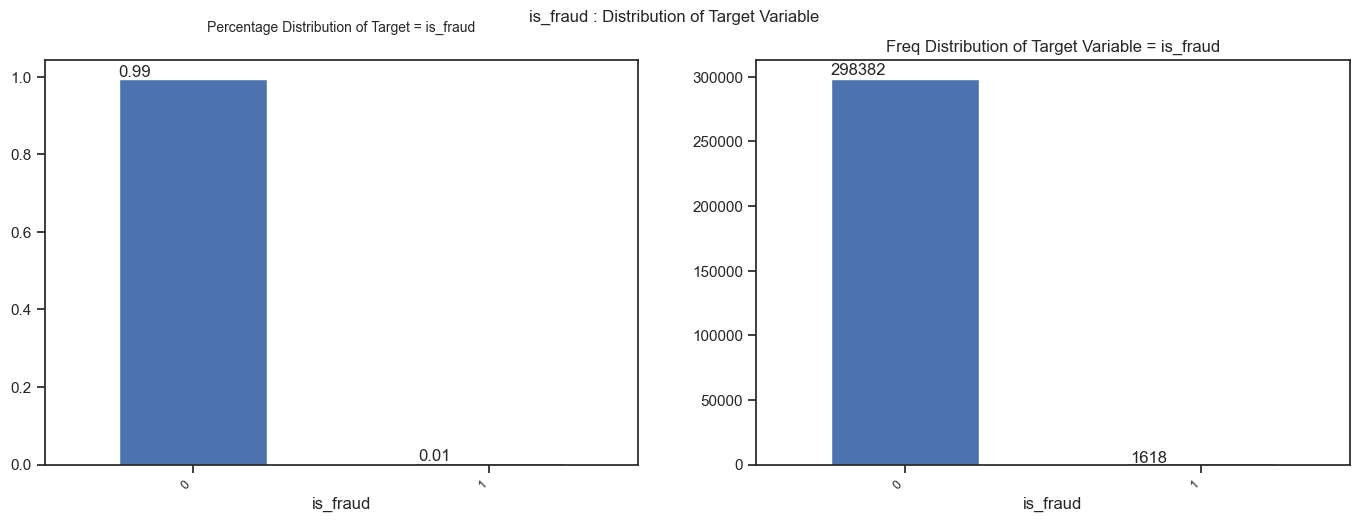

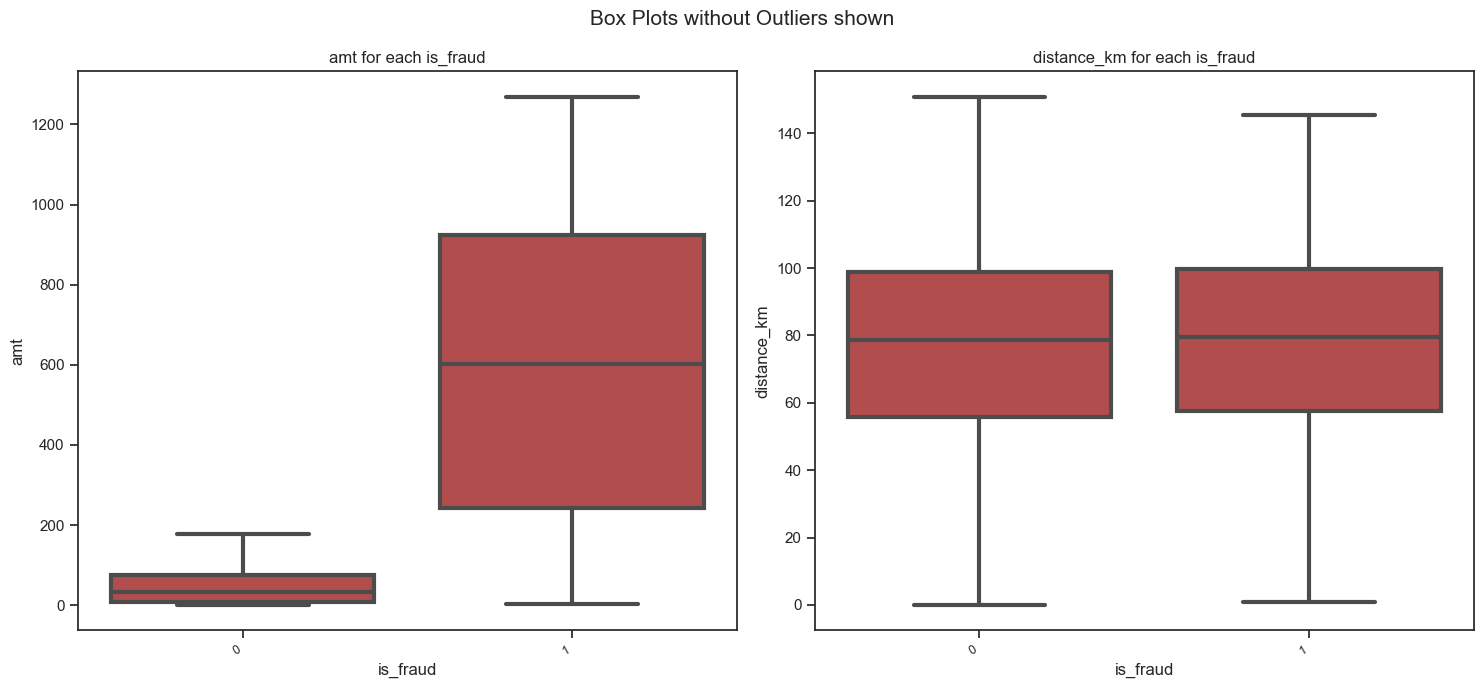

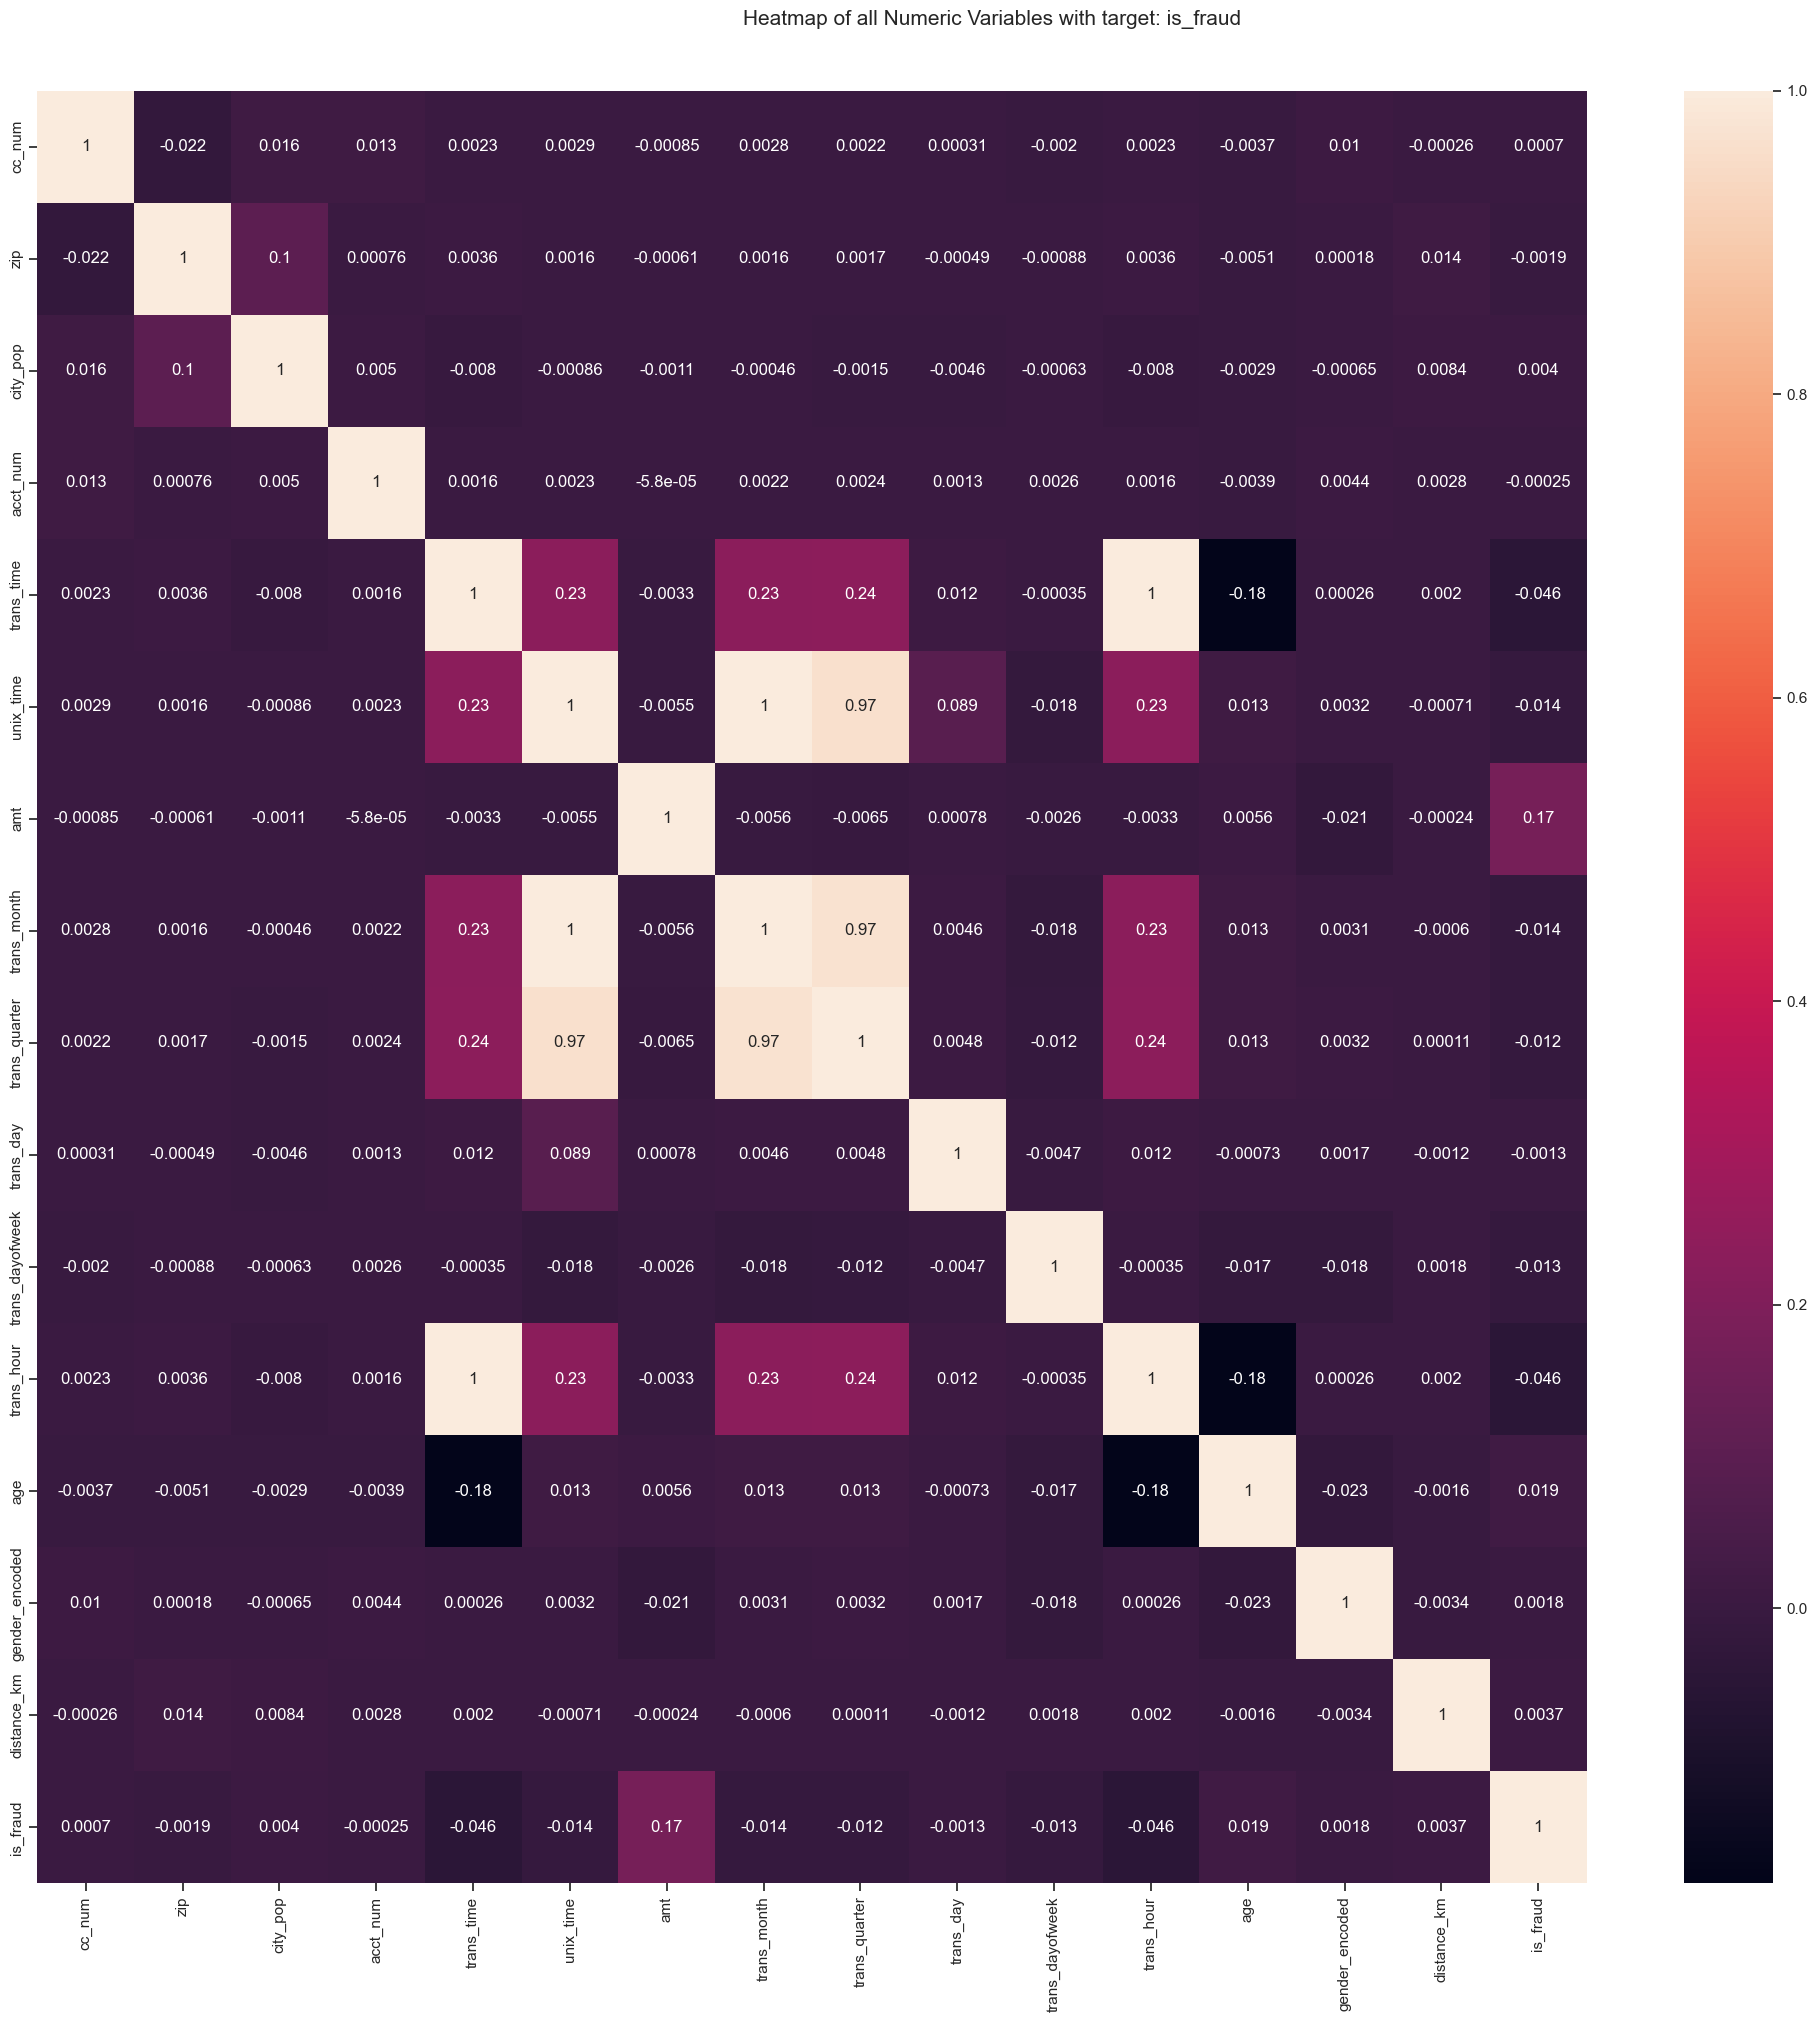

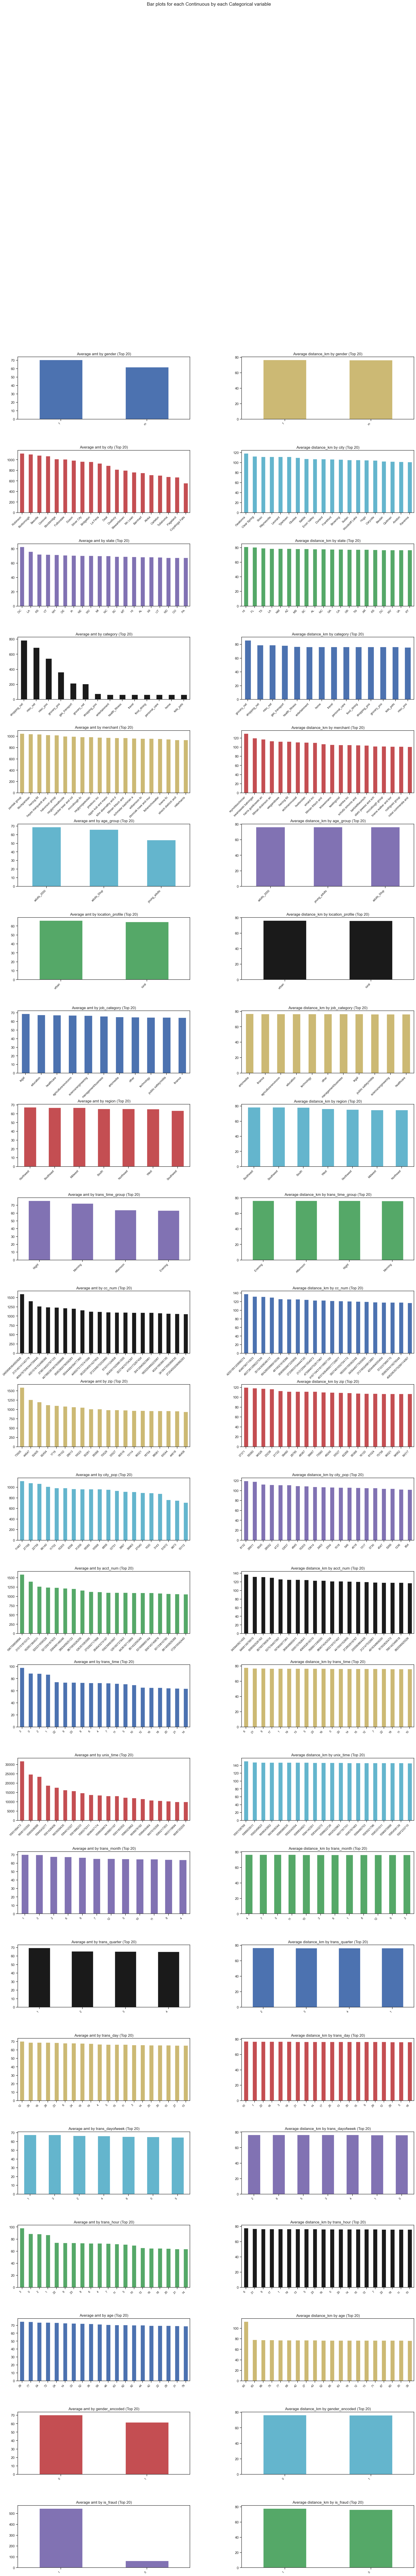

All Plots done
Time to run AutoViz = 88 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


,cc_num,gender,city,state,zip,city_pop,acct_num,trans_time,unix_time,category,amt,merchant,trans_month,trans_quarter,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,age_group,location_profile,job_category,region,trans_time_group,distance_km,is_fraud
238365,4837996898186,m,Inglewood,CA,90301,135222,440593167900,14,1592556326,health_fitness,33.03,hirthebeier,6,2,19,4,14,13,1,young_adults,urban,science/engineering,West,Afternoon,97.75,0
95471,180037997881663,m,Glendale,AZ,85308,280389,496671947313,15,1601459865,kids_pets,51.39,hoppeparisian,9,3,30,2,15,52,1,adults_50up,urban,management/business,Southwest,Afternoon,62.99,0
452358,348708698723623,m,West Haven,CT,6516,55564,91670510866,13,1599205429,home,28.16,windler goodwin and kovacek,9,3,4,4,13,38,1,adults_2550,urban,finance,Northeast,Afternoon,76.91,0
333688,340660939955928,m,Tucson,AZ,85730,865276,569986510342,12,1595919721,home,8.27,moore williamson and emmerich,7,3,28,1,12,42,1,adults_2550,urban,other,Southwest,Afternoon,103.55,0
374917,3554098113830218,m,Bronx,NY,10457,1382480,344407974530,18,1591190761,health_fitness,125.96,klocko runolfsdottir and breitenberg,6,2,3,2,18,54,1,adults_50up,urban,healthcare,Northeast,Evening,124.34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117896,4932796114528,m,Lakewood,CA,90715,79812,656188286380,13,1601278390,kids_pets,7.67,gleason and sons,9,3,28,0,13,17,1,young_adults,urban,legal,West,Afternoon,23.04,0
414178,6580048402813400,m,Olympia,WA,98506,167094,770699332982,14,1604047484,kids_pets,1.58,pouros walker and spencer,10,4,30,4,14,19,1,young_adults,urban,healthcare,West,Afternoon,71.49,0
216579,501873782905,m,Federal Way,WA,98003,91661,169234540897,16,1590924517,health_fitness,77.04,kulas group,5,2,31,6,16,48,1,adults_50up,urban,other,West,Afternoon,45.32,0
377771,4720710113589,f,Crestview,FL,32536,44788,843314396787,21,1604851006,personal_care,54.86,gottliebhansen,11,4,8,6,21,62,0,adults_50up,urban,other,Southeast,Evening,129.92,0


In [30]:
AV = AutoViz_Class()
AV.AutoViz(df_sample, depVar="is_fraud",max_rows_analyzed=300000)
           

In [34]:
# Fix for VisibleDeprecationWarning issue in Sweetviz (Monkey patch)

# Check if the attribute exists; if not, create it.
if not hasattr(np, "VisibleDeprecationWarning"):
    class VisibleDeprecationWarning(Warning):
        pass
    np.VisibleDeprecationWarning = VisibleDeprecationWarning

# Now Sweetviz can be safely imported.
import sweetviz as sv

report = sv.analyze(df, target_feat='is_fraud')
report.show_html()


                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [35]:
df.describe()

,cc_num,zip,city_pop,acct_num,trans_time,unix_time,amt,is_fraud,trans_month,trans_quarter,trans_day,trans_dayofweek,trans_hour,age,gender_encoded,distance_km
count,5.187720e+05,518772.00000,5.187720e+05,5.187720e+05,518772.000000,5.187720e+05,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000,518772.000000
mean,3.722211e+17,51085.88952,2.954341e+05,4.978119e+11,16.761302,1.595246e+09,65.955394,0.005420,7.118599,2.677502,15.850996,3.558224,16.761302,41.271967,0.482256,76.502266
std,1.238010e+18,29652.03775,5.679304e+05,2.891062e+11,4.532307,9.062085e+06,198.764070,0.073424,3.424153,1.094125,8.842200,1.947958,4.532307,17.883978,0.499686,29.191514
min,6.040003e+10,1002.00000,4.400000e+01,1.837412e+07,0.000000,1.577818e+09,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,11.000000,0.000000,0.060000
25%,3.850127e+13,27603.00000,1.778400e+04,2.465984e+11,14.000000,1.587835e+09,8.230000,0.000000,4.000000,2.000000,8.000000,2.000000,14.000000,27.000000,0.000000,55.670000
50%,3.505846e+15,48105.00000,6.089200e+04,4.972499e+11,17.000000,1.595409e+09,33.290000,0.000000,7.000000,3.000000,16.000000,4.000000,17.000000,39.000000,0.000000,78.710000
75%,4.589016e+15,78240.00000,2.366600e+05,7.505190e+11,20.000000,1.603292e+09,76.610000,0.000000,10.000000,4.000000,24.000000,5.000000,20.000000,53.000000,1.000000,98.920000
max,4.999689e+18,99929.00000,2.906700e+06,9.999583e+11,23.000000,1.609439e+09,31814.580000,1.000000,12.000000,4.000000,31.000000,6.000000,23.000000,93.000000,1.000000,150.860000


In [36]:
#export df to csv
df.to_csv("df_sample.csv", index=False)